## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import torch
import tqdm
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification

import data
import lib

## Model instantiation

In [3]:
model_id = "google/siglip2-large-patch16-384"  # FixRes вариант
processor = AutoImageProcessor.from_pretrained(model_id)  # даст resize/normalize, mean/std/size
# Веса энкодера + НОВАЯ голова классификации (num_labels=2):
model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=len(data.species_labels),
    ignore_mismatched_sizes=True,  # создаст новую голову нужного размера
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.tracking_loss = []
model.tracking_loss_val = []
model.epoch = 0

tracking_loss = model.tracking_loss
tracking_loss_val = model.tracking_loss_val

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip2-large-patch16-384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [21]:
# 2) Заморозим всё, кроме головы (линейный пробинг)
for name, p in model.named_parameters():
    p.requires_grad = ("classifier" in name)  # у HF-классификаторов голова обычно называется "classifier"

# Пример: соберите свои train/val списки файлов и меток
train_ds = lib.ForestDataset(data.x_train, data.y_train, processor=processor)
val_ds   = lib.ForestDataset(data.x_eval,   data.y_eval, processor=processor)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=4)

# 4) Баланс классов (простой вариант: веса в CrossEntropy по частотам)
# import numpy as np
# counts = np.bincount(train_labels, minlength=2)  # counts[0], counts[1]
# class_weights = torch.tensor((counts.sum() / (2.0 * np.maximum(counts, 1))), dtype=torch.float32, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 5) Оптимизируем ТОЛЬКО голову
head_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(head_params, lr=1e-3, weight_decay=0.01)

# 6) Тренировочный цикл (минимальный)

num_epochs = 1

for epoch in range(model.epoch, model.epoch + num_epochs):
    print(f"Starting epoch {epoch}")
    print(f"Training: ")

    model.train()

    loss_acc = 0
    count = 0

    for batch in tqdm.tqdm(train_loader, total=len(train_loader), ):
        optimizer.zero_grad(set_to_none=True)

        out = model(batch['pixel_values'].to('cuda'))              # logits: (B, 2)
        loss = criterion(out.logits, batch["labels"].to('cuda'))

        c = batch['pixel_values'].size(0)
        loss_acc += loss.item() * c
        count += c

        loss.backward()
        optimizer.step()

    tracking_loss.append(loss_acc / count)

    # валидация
    model.eval()

    loss_acc = 0

    with torch.no_grad():
        for batch in tqdm.tqdm(val_loader, total=len(val_loader)):
            out = model(batch['pixel_values'].to('cuda'))

            loss = criterion(out.logits, batch["labels"].to('cuda'))
            loss_acc += loss.item()

    tracking_loss_val.append(loss_acc / len(val_loader))

    lib.save_model(model, f"./models_siglip2/model_{str(epoch).rjust(2, "0")}.pth")

    model.epoch += 1

Starting epoch 0
Training: 


100%|██████████| 13/13 [01:15<00:00,  5.83s/it]


## Training progress

In [22]:
tracking_loss, tracking_loss_val

([1.3611963070355928, 1.2572567439996278, 1.205457078551957],
 [1.3471769461264977, 1.345654111642104])

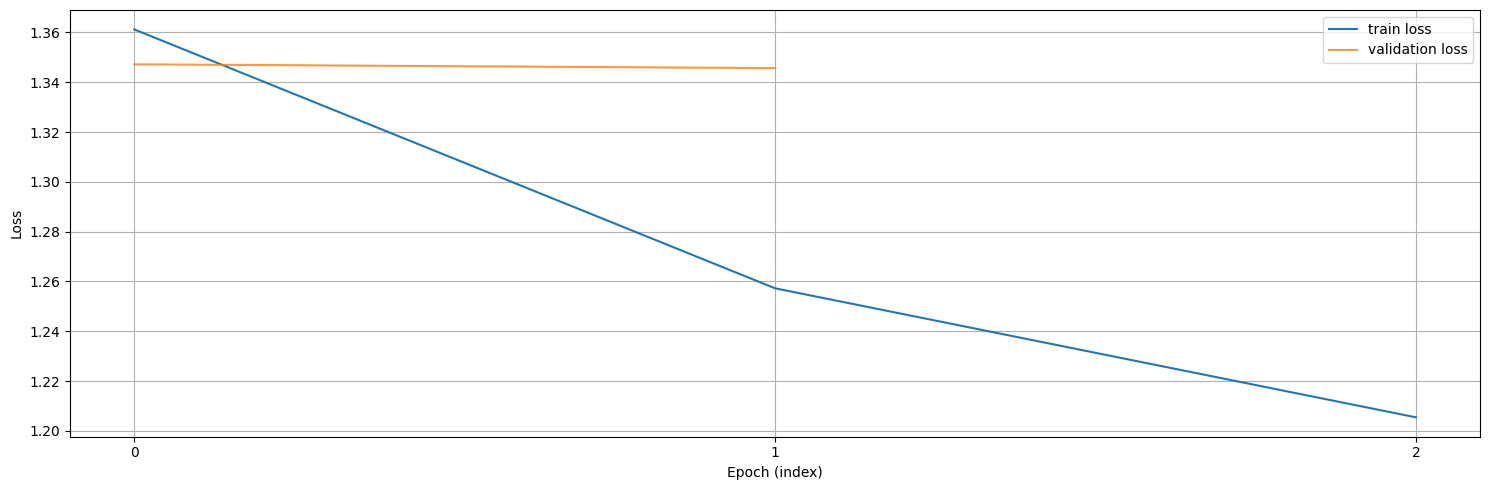

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
epochs_train = list(range(len(tracking_loss)))
epochs_val = list(range(len(tracking_loss_val)))
ax.plot(epochs_train, tracking_loss, label="train loss")
ax.plot(epochs_val, tracking_loss_val, label="validation loss", alpha=0.8)
ax.set_xlabel("Epoch (index)")
ax.set_ylabel("Loss")
ax.legend(loc="best")
ax.set_xticks(epochs_train)
ax.grid(True)
fig.tight_layout()


## Validation

In [29]:
T = 1

preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

model.to(torch.device("cuda"))

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm.tqdm(val_loader, total=len(val_loader)):
        # 1) run the forward step
        logits = model.forward(batch["pixel_values"].to(torch.device("cuda"))).logits
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits / T, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().to('cpu').numpy(),
            index=batch["image_id"],
            columns=data.species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 13/13 [01:15<00:00,  5.79s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ000000,0.208359,0.290532,0.212026,0.016879,0.014586,0.007786,0.092042,0.157790
ZJ000006,0.049364,0.007683,0.037221,0.269163,0.031884,0.009285,0.011342,0.584058
ZJ000011,0.161947,0.081721,0.285011,0.002472,0.062242,0.231614,0.071096,0.103895
ZJ000023,0.011383,0.001372,0.012289,0.123024,0.019982,0.826581,0.001639,0.003731
ZJ000024,0.136933,0.111336,0.028708,0.004637,0.011491,0.042691,0.624025,0.040180
...,...,...,...,...,...,...,...,...
ZJ016461,0.772984,0.083139,0.004154,0.005977,0.020155,0.015291,0.071875,0.026425
ZJ016462,0.190065,0.068205,0.189388,0.003475,0.080094,0.304746,0.071024,0.093002
ZJ016473,0.056201,0.005386,0.007348,0.509742,0.081385,0.044180,0.013181,0.282579
ZJ016475,0.040694,0.207995,0.237577,0.005702,0.053542,0.383407,0.056552,0.014531


In [30]:
print("True labels (training):")
data.y_train.idxmax(axis=1).value_counts(normalize=True)

True labels (training):


monkey_prosimian    0.172328
blank               0.157544
antelope_duiker     0.151554
rodent              0.123730
leopard             0.116452
bird                0.112585
civet_genet         0.108870
hog                 0.056937
Name: proportion, dtype: float64

In [31]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts(normalize=True)

Predicted labels (eval):


rodent              0.226501
civet_genet         0.191328
blank               0.123711
leopard             0.107944
antelope_duiker     0.104002
monkey_prosimian    0.095209
hog                 0.087629
bird                0.063675
Name: proportion, dtype: float64

In [32]:
print("True labels (eval):")
data.y_eval.idxmax(axis=1).value_counts(normalize=True)

True labels (eval):


civet_genet         0.299272
leopard             0.217708
antelope_duiker     0.144027
rodent              0.115525
hog                 0.068830
monkey_prosimian    0.066404
bird                0.047301
blank               0.040934
Name: proportion, dtype: float64

In [33]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_true = data.y_eval.idxmax(axis=1)

In [34]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy.item()

0.5767131594906003

### Confusion matrix

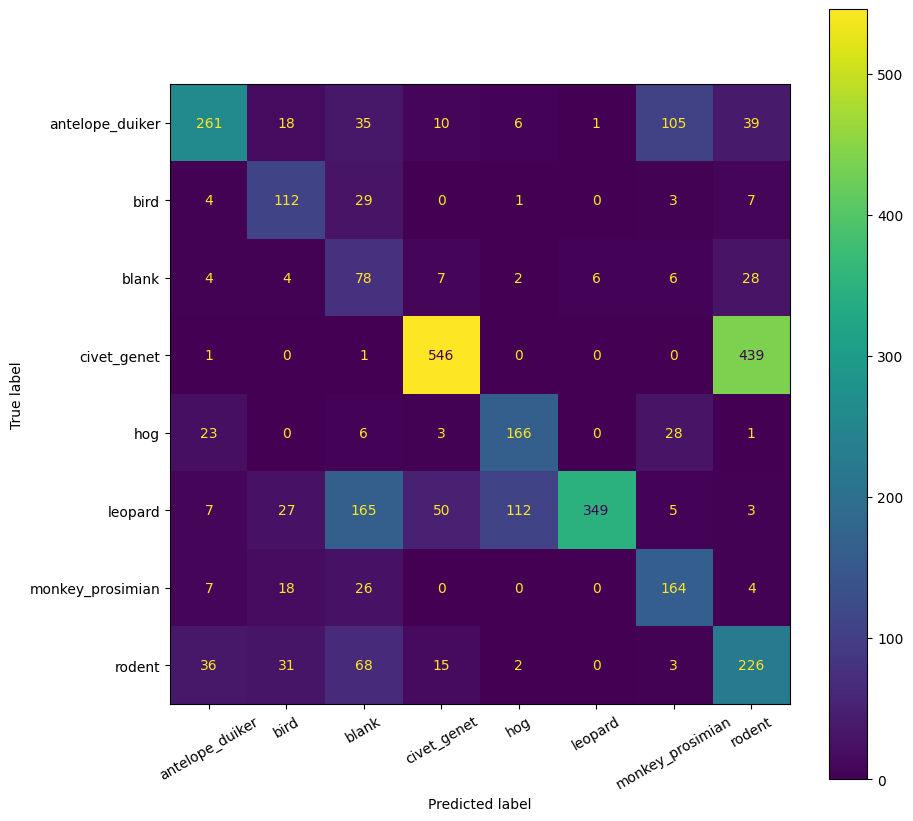

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    data.y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=30,
    colorbar=True,
)